# Загружаем датасет

In [1]:
! wget https://www.dropbox.com/s/gibmz16sa44ybh3/PH2Dataset.rar?dl=0

--2022-04-06 12:52:37--  https://www.dropbox.com/s/gibmz16sa44ybh3/PH2Dataset.rar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gibmz16sa44ybh3/PH2Dataset.rar [following]
--2022-04-06 12:52:38--  https://www.dropbox.com/s/raw/gibmz16sa44ybh3/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5765e728f0a2b501a2c08c919d.dl.dropboxusercontent.com/cd/0/inline/Bi5fVoAk7Oi_hxGHaexodxkF2eBZ-ZxJYTq7FZrYpmguoSEsrkqRWpve6SchIyWZVUdK2kPiRtaaL9zcxtzSlXchcu-OHMDTMM28TsmDqmPaaL5U3lBzKvjdgFAl8yqKcS5zJERh7w0WitdSmWyZaDgRaEvr2CYWgwsxKDXb24PemQ/file# [following]
--2022-04-06 12:52:38--  https://uc5765e728f0a2b501a2c08c919d.dl.dropboxusercontent.com/cd/0/inline/Bi5fVoAk7Oi_hxGHaexodxkF2eBZ-ZxJYTq7FZrYpmguoSEsrkqRWpve6

In [2]:
! pip install rarfile

In [3]:
import rarfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path
from PIL import Image
import cv2
import os
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange

In [4]:
r = rarfile.RarFile('/content/PH2Dataset.rar?dl=0')
r.extractall()

# Читаем датасет

In [5]:
images = []
lesions = []
root = Path('/content/PH2Dataset/PH2 Dataset images/')

for file_ in root.rglob('*.bmp'):
    file_ = str(file_)
    if 'Dermoscopic_Image' in file_:
        images.append(file_)
    if 'lesion' in str(file_):
        lesions.append(file_)
images = np.array(images)
lesions = np.array(lesions)

In [6]:
class PH2Dataset(Dataset):
      def __init__(self, images, masks, transform, mask_transform):
          super().__init__()
          self.images = images
          self.masks = masks
          self.transform = transform
          self.mask_transform = mask_transform

      def __len__(self):
          return len(self.images)

      def __getitem__(self, index):
          x = cv2.imread(self.images[index])
          x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
          x = Image.fromarray(x)
          if self.transform is not None:
             x = self.transform(x)

          y = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
          y = Image.fromarray(y)
          if self.mask_transform is not None:
             y = self.mask_transform(y)
          return x, y

      def visualize(self, index):
          x = cv2.imread(self.images[index])
          x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
          plt.figure(figsize=(10, 10))
          plt.axis('off')
          plt.imshow(x)

# Transforms

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# Train test split

In [8]:
from sklearn.model_selection import train_test_split
images_train, X_test, lesions_train, y_test = train_test_split(images, lesions, test_size = 0.5)

In [9]:
images_valid, images_test, lesions_valid, lesions_test = train_test_split(X_test, y_test, test_size = 0.5)

In [10]:
train_dataset = PH2Dataset(images_train, lesions_train, train_transform, mask_transform)
valid_dataset = PH2Dataset(images_valid, lesions_valid, train_transform, mask_transform)

# DataLoaders

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=1,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

# Models

### UNET

In [12]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


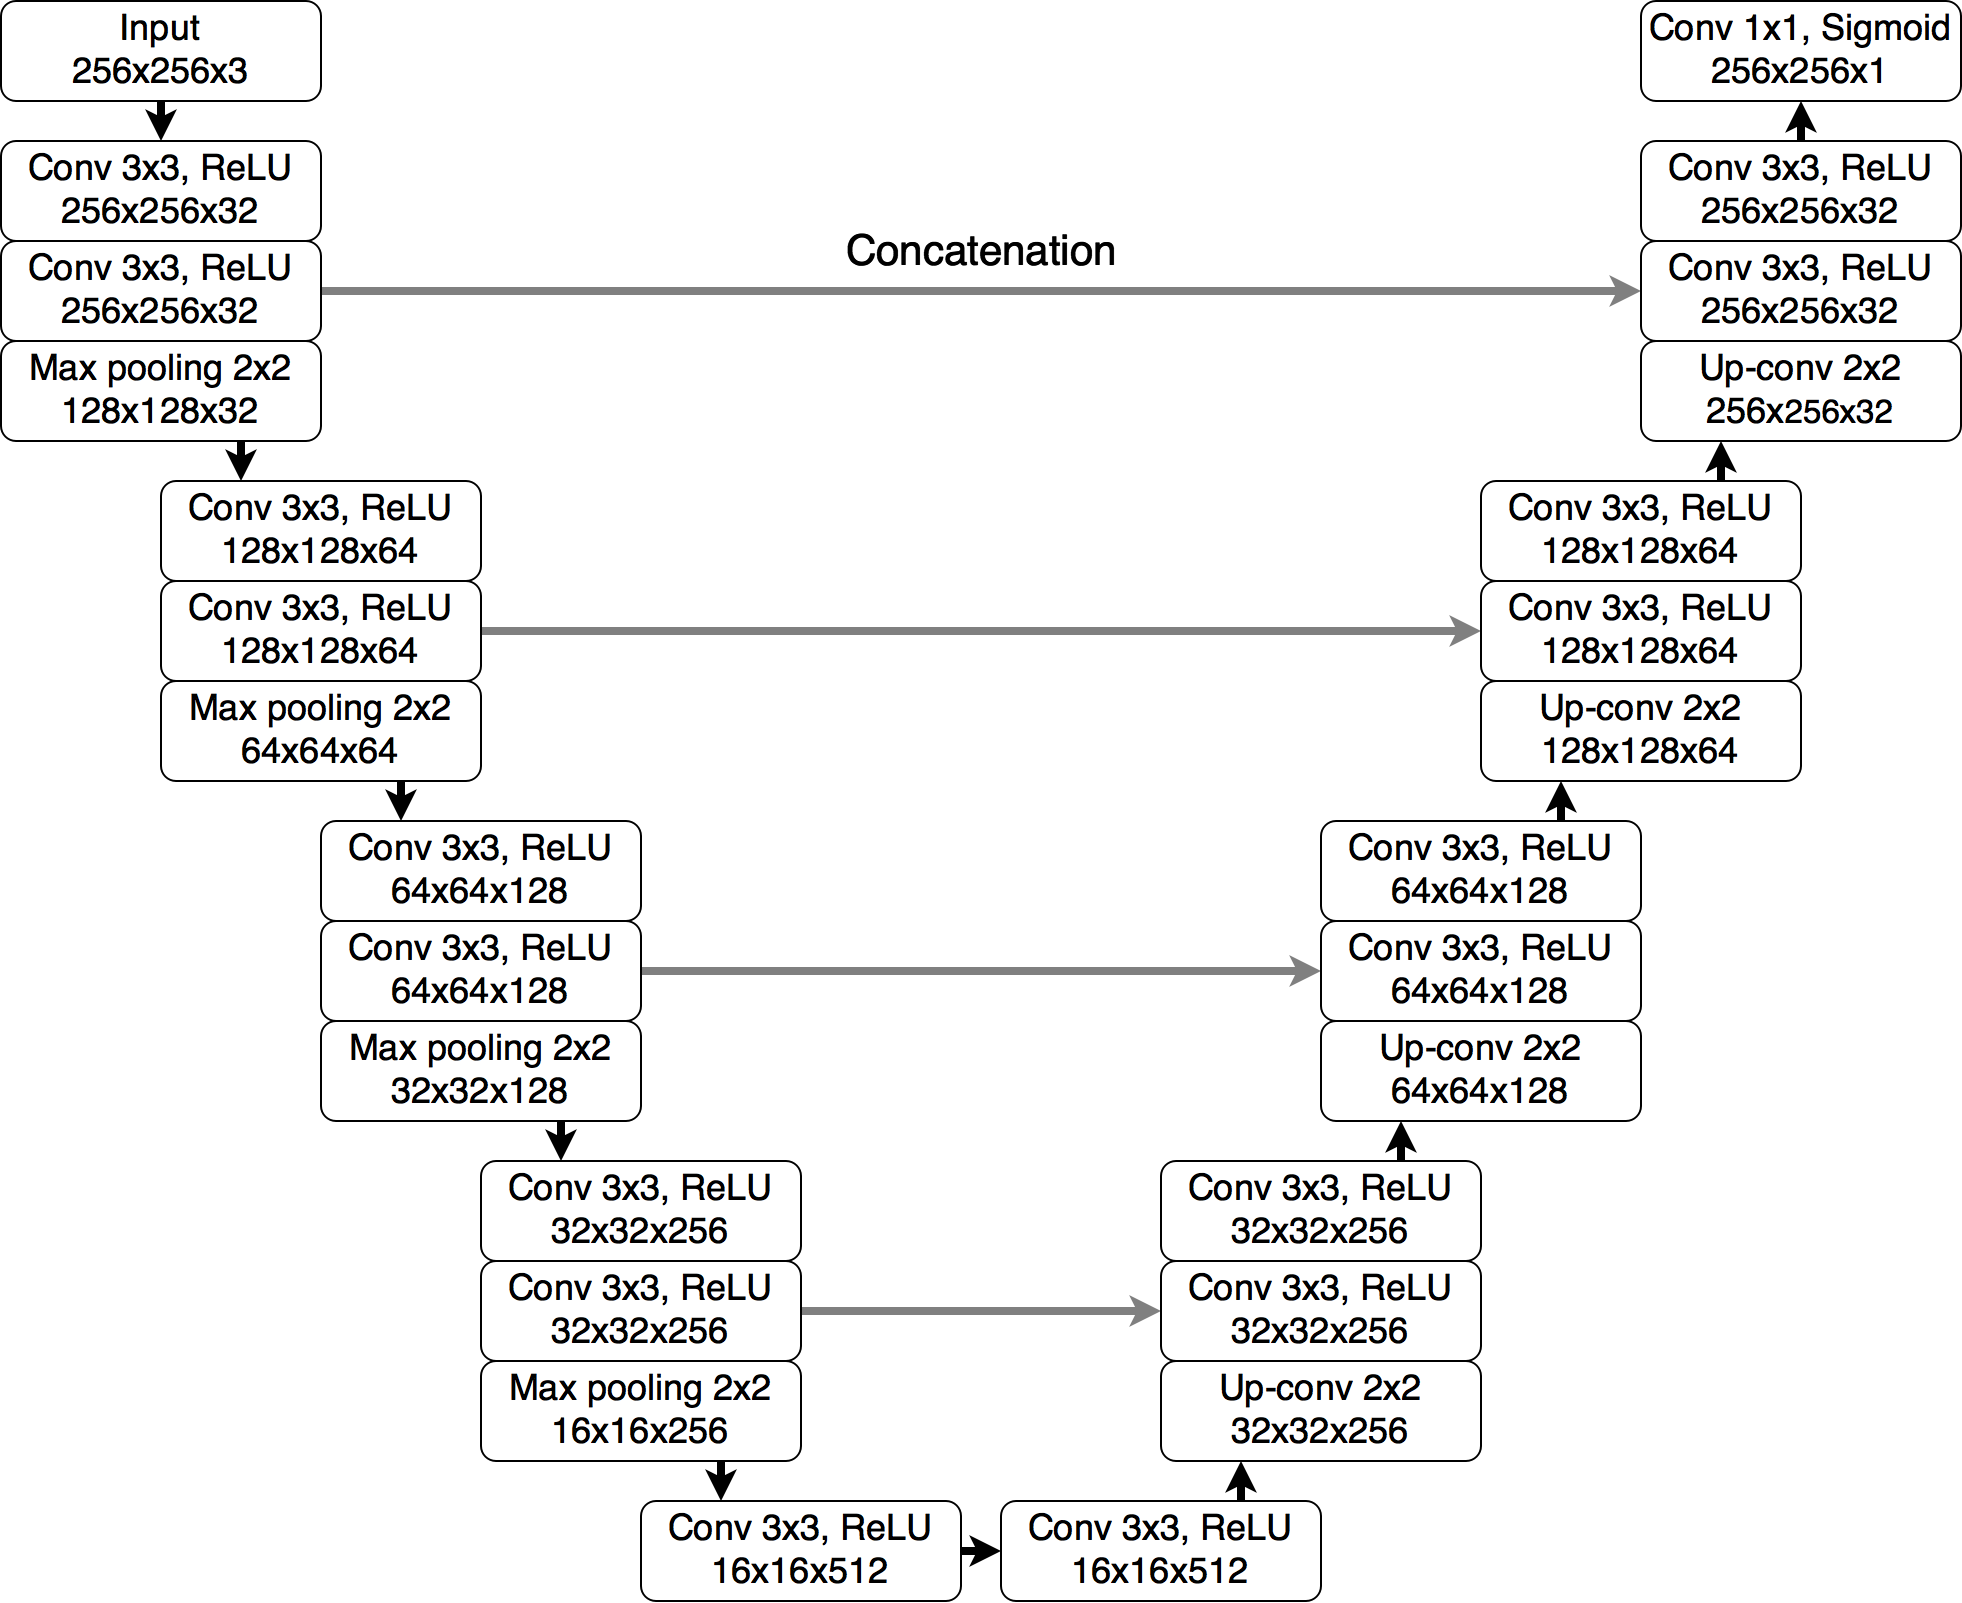

In [13]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Train loop

In [38]:
def fit_epoch(model, train_loader, criterion, opt):
    model.train()
    total_loss=0
    num_batches=0
    for images, masks in train_loader:
        
        images = images.to(torch.device("cuda"))
        masks = masks.to(torch.device("cuda"))
        opt.zero_grad()
        pred_masks = model(images)
        
        loss = criterion(pred_masks, masks) 
        loss.backward()
        opt.step()
        total_loss += loss.item() #mean loss for batch
        num_batches += 1 #number of pictures
    return total_loss/num_batches

In [39]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    total_loss=0
    num_batches=0
    for images, masks in val_loader:
        images = images.to(torch.device("cuda"))
        masks = masks.to(torch.device("cuda"))
        with torch.no_grad():
             pred_masks = model(images)
             loss = criterion(pred_masks, masks)

             total_loss += loss.item() #mean loss for batch
             num_batches += 1 #number of batches
    return total_loss/num_batches

In [40]:
def train(train_dataloader, val_dataloader, model, epochs, opt, criterion):
    for epoch in trange(epochs, desc="Epoch:"):
        train_loss = fit_epoch(model, train_dataloader, criterion, opt)
        val_loss = eval_epoch(model, val_dataloader, criterion)
        print("Train Loss: ", train_loss)
        print("Validation Loss: ", val_loss)

In [17]:
!pip install torchmetrics
from torchmetrics import JaccardIndex

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

In [33]:
model = model.to(torch.device("cuda"))

In [ ]:
model

In [41]:
train(train_loader, valid_loader, model, 10, optimizer, criterion)

Epoch::  10%|█         | 1/10 [00:11<01:45, 11.72s/it]

Train Loss:  1.172693432420492
Validation Loss:  0.5729740526899696


Epoch::  20%|██        | 2/10 [00:22<01:31, 11.46s/it]

Train Loss:  0.519021083638072
Validation Loss:  0.467415612898767


Epoch::  30%|███       | 3/10 [00:34<01:19, 11.39s/it]

Train Loss:  0.41898271940648557
Validation Loss:  0.5354370455443859


Epoch::  40%|████      | 4/10 [00:45<01:08, 11.36s/it]

Train Loss:  0.35913390323519706
Validation Loss:  0.4922847592830658


Epoch::  50%|█████     | 5/10 [00:56<00:56, 11.35s/it]

Train Loss:  0.31420639984309673
Validation Loss:  0.40365436621010303


Epoch::  60%|██████    | 6/10 [01:08<00:45, 11.34s/it]

Train Loss:  0.2794300906360149
Validation Loss:  0.2953393153101206


Epoch::  70%|███████   | 7/10 [01:19<00:33, 11.33s/it]

Train Loss:  0.2656390947662294
Validation Loss:  0.44273922219872475


Epoch::  80%|████████  | 8/10 [01:30<00:22, 11.32s/it]

Train Loss:  0.22535764939151703
Validation Loss:  0.3593172466009855


Epoch::  90%|█████████ | 9/10 [01:42<00:11, 11.33s/it]

Train Loss:  0.20797102973796427
Validation Loss:  0.33345776654779913


Epoch:: 100%|██████████| 10/10 [01:53<00:00, 11.35s/it]

Train Loss:  0.1946736469771713
Validation Loss:  0.37775693520903586


# Predictions

In [55]:
def predict(model, data):
    model.eval()  # testing mode
    pred_masks = []
    for img, _ in data:
        img = img.to(torch.device("cuda"))
        with torch.no_grad():
          mask = model(img).to(torch.device("cpu"))
          pred_masks.append(mask)
    return np.array(pred_masks)

In [51]:
test_dataset = PH2Dataset(images_test, lesions_test, valid_transform, mask_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

In [56]:
res = predict(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':
